Found match: U.S.
Found match: US


,index,text,lemma,upos,xpos,entity
0,1,The United States of America,The United States of America,PROPN,NNP,"[GPE, B]"
1,2,(,(,PUNCT,-LRB-,"[, O]"
2,3,USA,USA,PROPN,NNP,"[, O]"
3,4,),),PUNCT,-RRB-,"[, O]"
4,5,are,be,AUX,VBP,"[, O]"
5,6,commonly,commonly,ADV,RB,"[, O]"
6,7,known,know,VERB,VBN,"[, O]"
7,8,as,as,SCONJ,IN,"[, O]"
8,9,the United States,the United States,PROPN,NNP,"[GPE, B]"
9,10,(,(,PUNCT,-LRB-,"[, O]"


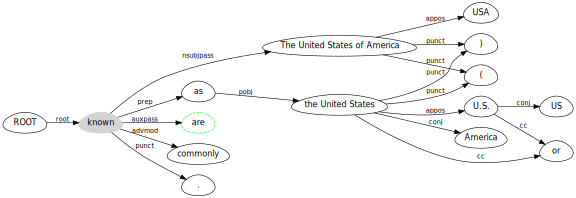

In [3]:
from sagas.nlu.spacy_helper import spacy_mgr, vis
import re
from spacy import displacy
from sagas.tracker_jupyter import enable_jupyter_tracker

enable_jupyter_tracker()
nlp = spacy_mgr.get_model('en')
text="The United States of America (USA) are commonly known as the United States (U.S. or US) or America."
doc = nlp(text)

expression = r"[Uu](nited|\.?) ?[Ss](tates|\.?)"
for match in re.finditer(expression, doc.text):
    start, end = match.span()
    span = doc.char_span(start, end)
    # This is a Span object or None if match doesn't map to valid token sequence
    if span is not None:
        print("Found match:", span.text)

# displacy.render([doc], style="dep")
vis(doc, text)

In [4]:
nlp.pipe_names

['tagger', 'parser', 'ner', 'merge_entities', 'extract_person_orgs']

In [2]:
from spacy.matcher import Matcher

matcher = Matcher(nlp.vocab)
pattern = [{"ORTH": "("}, {"SHAPE": "ddd"}, {"ORTH": ")"}, {"SHAPE": "ddd"},
           {"ORTH": "-", "OP": "?"}, {"SHAPE": "ddd"}]
matcher.add("PHONE_NUMBER", None, pattern)

doc = nlp("Call me at (123) 456 789 or (123) 456 789!")
print([t.text for t in doc])
matches = matcher(doc)
for match_id, start, end in matches:
    span = doc[start:end]
    print(span.text)

['Call', 'me', 'at', '(', '123', ')', '456', '789', 'or', '(', '123', ')', '456', '789', '!']
(123) 456 789
(123) 456 789


In [3]:
matcher = Matcher(nlp.vocab)
matched_sents = []  # Collect data of matched sentences to be visualized

def collect_sents(matcher, doc, i, matches):
    match_id, start, end = matches[i]
    span = doc[start:end]  # Matched span
    sent = span.sent  # Sentence containing matched span
    # Append mock entity for match in displaCy style to matched_sents
    # get the match span by ofsetting the start and end of the span with the
    # start and end of the sentence in the doc
    match_ents = [{
        "start": span.start_char - sent.start_char,
        "end": span.end_char - sent.start_char,
        "label": "MATCH",
    }]
    matched_sents.append({"text": sent.text, "ents": match_ents})

pattern = [{"LOWER": "facebook"}, {"LEMMA": "be"}, {"POS": "ADV", "OP": "*"},
           {"POS": "ADJ"}]
matcher.add("FacebookIs", collect_sents, pattern)  # add pattern
doc = nlp("I'd say that Facebook is evil. – Facebook is pretty cool, right?")
matches = matcher(doc)

# Serve visualization of sentences containing match with displaCy
# set manual=True to make displaCy render straight from a dictionary
# (if you're not running the code within a Jupyer environment, you can
# use displacy.serve instead)
displacy.render(matched_sents, style="ent", manual=True)

In [4]:
from spacy.tokens import Token

# We're using a class because the component needs to be initialised with
# the shared vocab via the nlp object
class BadHTMLMerger(object):
    def __init__(self, nlp):
        # Register a new token extension to flag bad HTML
        Token.set_extension("bad_html", default=False)
        self.matcher = Matcher(nlp.vocab)
        self.matcher.add(
            "BAD_HTML",
            None,
            [{"ORTH": "<"}, {"LOWER": "br"}, {"ORTH": ">"}],
            [{"ORTH": "<"}, {"LOWER": "br/"}, {"ORTH": ">"}],
        )

    def __call__(self, doc):
        # This method is invoked when the component is called on a Doc
        matches = self.matcher(doc)
        spans = []  # Collect the matched spans here
        for match_id, start, end in matches:
            spans.append(doc[start:end])
        with doc.retokenize() as retokenizer:
            for span in spans:
                retokenizer.merge(span)
                for token in span:
                    token._.bad_html = True  # Mark token as bad HTML
        return doc

html_merger = BadHTMLMerger(nlp)
nlp.add_pipe(html_merger, last=True)  # Add component to the pipeline
doc = nlp("Hello<br>world! <br/> This is a test.")
for token in doc:
    print(token.text, token._.bad_html)

Hello False
<br> True
world False
! False
<br/> True
This False
is False
a False
test False
. False


,index,text,lemma,upos,xpos,entity
0,1,Alex,Alex,PROPN,NNP,"[PERSON, B]"
1,2,Smith,Smith,PROPN,NNP,"[PERSON, I]"
2,3,was,be,AUX,VBD,"[, O]"
3,4,working,work,VERB,VBG,"[, O]"
4,5,at,at,ADP,IN,"[, O]"
5,6,Acme,Acme,PROPN,NNP,"[ORG, B]"
6,7,Corp,Corp,PROPN,NNP,"[ORG, I]"
7,8,Inc.,Inc.,PROPN,NNP,"[ORG, I]"


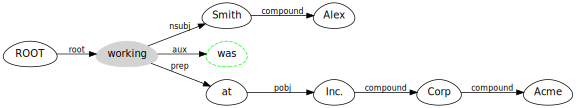

In [5]:
sents="Alex Smith was working at Acme Corp Inc."
doc = nlp(sents)
vis(doc,sents)

{'person': Alex Smith, 'orgs': [Acme Corp Inc.], 'past': True}


,index,text,lemma,upos,xpos,entity
0,1,Alex Smith,Alex Smith,PROPN,NNP,"[PERSON, B]"
1,2,worked,work,VERB,VBD,"[, O]"
2,3,at,at,ADP,IN,"[, O]"
3,4,Acme Corp Inc.,Acme Corp Inc.,PROPN,NNP,"[ORG, B]"


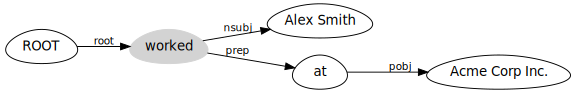

In [1]:
from spacy.pipeline import merge_entities
from sagas.nlu.spacy_helper import spacy_mgr, vis
import re
from spacy import displacy
from sagas.tracker_jupyter import enable_jupyter_tracker

enable_jupyter_tracker()
nlp = spacy_mgr.get_model('en')

def extract_person_orgs(doc):
    person_entities = [ent for ent in doc.ents if ent.label_ == "PERSON"]
    for ent in person_entities:
        head = ent.root.head
        if head.lemma_ == "work":
            preps = [token for token in head.children if token.dep_ == "prep"]
            for prep in preps:
                orgs = [token for token in prep.children if token.ent_type_ == "ORG"]
                print({'person': ent, 'orgs': orgs, 'past': head.tag_ == "VBD"})
    return doc

# To make the entities easier to work with, we'll merge them into single tokens
nlp.add_pipe(merge_entities)
nlp.add_pipe(extract_person_orgs)

sents="Alex Smith worked at Acme Corp Inc."
doc = nlp(sents)
# If you're not in a Jupyter / IPython environment, use displacy.serve
# displacy.render(doc, options={'fine_grained': True})
vis(doc,sents)

{'person': Alex Smith, 'orgs': [Acme Corp Inc.], 'past': False}


,index,text,lemma,upos,xpos,entity
0,1,Alex Smith,Alex Smith,PROPN,NNP,"[PERSON, B]"
1,2,was,be,AUX,VBD,"[, O]"
2,3,working,work,VERB,VBG,"[, O]"
3,4,at,at,ADP,IN,"[, O]"
4,5,Acme Corp Inc.,Acme Corp Inc.,PROPN,NNP,"[ORG, B]"


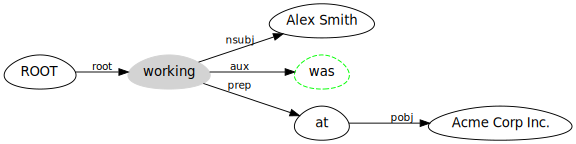

In [2]:
# sents="Alex Smith worked at Acme Corp Inc."
sents="Alex Smith was working at Acme Corp Inc."
doc = nlp(sents)
vis(doc,sents)